In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy
import plotly.express as px
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords  
stop_words= stopwords.words('english')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

I have used IMDB dataset to get ratings for shows, you can download that from my notebook

In [ ]:
data=pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")
detailNetflix = pd.read_csv('../input/imdb-dataset-titles-and-rating/title.akas.tsv',sep='\t')
rating = pd.read_csv('../input/imdb-dataset-titles-and-rating/title.ratings.tsv',sep='\t')
data.head()

Analysis will be based on
* Type 
* Country
* Date_added and Release Year
* listed_in

Task that are covered are: 
* Netflix distribution over Type
* Best rated movies in Netflix
* Netflix shows distribution over Countries
* Genre distribution in India and US
* Netflix Original Vs Licenced

# Movies vs Shows

In [ ]:
netflixDistribution = pd.DataFrame(data['type'].value_counts())
netflixDistribution.reset_index(inplace=True)
fig = px.pie(netflixDistribution, 'index', 'type',title ='Content type distribution in Netflix')
fig.update_traces(
                  marker = dict(colors = ['#213970','#1ee3e0'], line = dict(color = 'white', width = 4)))
fig.update_layout(legend_title=dict(text='Type'))
fig.show()

Clearly TV shows are more in Netflix. This is because that it for longer time, has user end up spending more time in Netflix and zest to watch more shows devlops

In [ ]:
detailNetflix.head()

In [ ]:
rating.head()

In [ ]:
netflixRating = pd.merge(detailNetflix,rating,how = 'left',left_on='titleId',right_on='tconst')
filterNetflixRating=netflixRating[['titleId','title','averageRating','numVotes']].drop_duplicates()
avgNetflixRating =filterNetflixRating.groupby('title',as_index=False)['averageRating','numVotes'].mean()
dataRating =  pd.merge(data,avgNetflixRating,how = 'left',on='title')
dataRating.head()

In [ ]:
dataRating.isna().sum()

In [ ]:
movieData = dataRating[dataRating['type'] =='Movie']
notNullmovieData = movieData[movieData.averageRating.isna() == False]
notNullmovieData.sort_values(by='averageRating', ascending=False,inplace=True)

#  Best Rated Movies in Netflix

In [ ]:
notNullmovieData['title'].head(10)

Interesting to know most rated movies in Netflix
Have you watched all of them ?
![](http://)

In [ ]:
countrylist = [str(i).split(', ') for i in dataRating['country']]
adjCountrylist =[]
for i in countrylist:
    for j in i:
        if j not in adjCountrylist:
            adjCountrylist.append(j)
dfCountry = pd.DataFrame()
dfCountry['country']=adjCountrylist
dfCountry.reset_index(inplace=True)

dataRatingCountries=pd.DataFrame()
dataRating['countryEqual1']=dataRating['country'].str.find(', ') == -1.0
dataRatingCountries = copy.deepcopy(dataRating[dataRating['countryEqual1']==True])
dataRatingCountries['countrySplit']=dataRatingCountries['country']
dataRatingCountryGrtrThan1 = copy.deepcopy(dataRating[dataRating['countryEqual1']==False])
for index, row in dataRatingCountryGrtrThan1.iterrows():
    countriesListRow = str(row['country']).split(', ')
    for i in countriesListRow:
        row['countrySplit']=i
        dataRatingCountries=dataRatingCountries.append(row)
        
dataRatingCountries=pd.merge(dataRatingCountries,dfCountry,how='left',left_on='countrySplit',right_on='country')
dataRatingCountries.rename(columns={'index':'countryCode','country_y':'country'},inplace=True)
dataRatingCountries.drop(columns={'country_x','countryEqual1','countrySplit'},inplace=True)

# Netflix Shows Distribution over Countries

In [ ]:
CountryCountSeries = dataRatingCountries.groupby('country')['show_id'].count()
dfCountryCount=pd.DataFrame(CountryCountSeries)
dfCountryCount.reset_index(inplace=True)
dfCountryCount.sort_values(by=['show_id'], ascending=False, inplace=True)
fig = px.pie(dfCountryCount.head(10), 'country', 'show_id',title ='Distribution in Countries')
fig.update_traces(
                  marker = dict(colors = ['#213970','#2f519e','#406bc9','#5185f5','#51a6f5','#83c2fc','#83d8fc','#89f2fa','#42fffc','#1ee3e0'], line = dict(color = 'white', width = 4)))

fig.update_layout(legend_title=dict(text='Country Plot'))
fig.show()

Clearly, US has major stake with 45% of shows in Netflix.

# Distribution of Netflix shows/Movies over yrs

In [ ]:
def barGraph(data,col='',title=''):
    series = data[col].value_counts()
    df=pd.DataFrame(series)
    df.reset_index(inplace=True)
    df.sort_values(by=[col], ascending=False, inplace=True)
    df.rename(columns={col:'count','index':col},inplace=True)
    fig = px.bar(df, col, 'count',color= col,title = title)
    fig.update_traces(marker = dict(color = ['#213970','#213970','#213970','#213970','#83c2fc','#83c2fc','#83c2fc','#89f2fa','#89f2fa','#89f2fa','#1ee3e0','#1ee3e0','#1ee3e0']))
    fig.update_layout(legend_title=dict(text=col))
    fig.show()

barGraph(dataRating,'release_year','Distribution of Netflix shows/Movies')

In [ ]:
def barGraphDefaultColor(data,col='',title=''):
    series = data[col].value_counts()
    df=pd.DataFrame(series)
    df.reset_index(inplace=True)
    df.sort_values(by=[col], ascending=False, inplace=True)
    df.rename(columns={col:'count','index':col},inplace=True)
    fig = px.bar(df, col, 'count',color= col,title = title)
    fig.update_layout(legend_title=dict(text=col))
    fig.show()

* 2020 is exception year, so less releases in that year is expected.
* But in 2019 it can be seen lesser releases compared to 2018 

In [ ]:
movieData = dataRating[dataRating['type']=='Movie']
movieData=movieData[movieData['release_year']>1990]
barGraph(movieData,'release_year','Distribution of movies over yrs')

In [ ]:
showData = dataRating[dataRating['type']=='TV Show']
showData=showData[showData['release_year']>1990]
barGraph(showData,'release_year','Distribution of TV Show over yrs')

* It is suprizing to see decrease in TV shows in 2019.
* 2020 being pandemic yr, 457 movies are released in 2020, which is great acheivement for Netlflix

In [ ]:
dataRatingGenre=pd.DataFrame()
dataRating['andSplit']=dataRating['listed_in'].str.find('&') != -1.0
dataRating['andSplit']=dataRating['andSplit'].apply(lambda x:int(x))
dataRating['commaSplit']= dataRating['listed_in'].str.find(', ') != -1.0
dataRating['commaSplit']=dataRating['commaSplit'].apply(lambda x:int(x))
dataRating['mulGenre']=dataRating['commaSplit']+dataRating['andSplit']
dataRating['mulGenre']=dataRating['mulGenre'].apply(lambda x:bool(x))
timestart= datetime.now()
dataRatingGenre = copy.deepcopy(dataRating[dataRating['mulGenre']==False])
dataRatingGenre['generSplit']=dataRatingGenre['listed_in']
dataRatingGenreGrtrThan1 = copy.deepcopy(dataRating[dataRating['mulGenre']==True])
for index, row in dataRatingGenreGrtrThan1.iterrows():
    ListRow = str(row['listed_in']).split(', ')
    for i in ListRow:
        moreSplit = str(i).split(' & ')
        for j in moreSplit:
            row['generSplit']=j
            dataRatingGenre=dataRatingGenre.append(row)
 

In [ ]:
dataRatingGenreIndia = dataRatingGenre[dataRatingGenre['country']=='India']
barGraphDefaultColor(dataRatingGenreIndia,'generSplit','Distribution of Genre India')

In [ ]:
dataRatingGenreUS = dataRatingGenre[dataRatingGenre['country']=='United States']
barGraphDefaultColor(dataRatingGenreUS,'generSplit','Distribution of Genre US')

* Very Evident, Indians releases more International movies.
* Americans release more Dramas 
* Americans love to see more Documentaries,while Indians hardly sees any.

# Netflix Vs Licenced

Assumption if it is a netflix show, it will be released in same Yr in netflix as its release date.
If it is not, it is not a netflix show.

In [ ]:
dataRating['date_added_year']=dataRating['date_added'].str.split(', ', n = 1, expand = True)[1]
dataRating['date_added_year'].fillna(0,inplace=True)
dataRating['date_added_year'] = dataRating['date_added_year'].astype('int64')
dataRating['release_year'] = dataRating['release_year'].astype('int64')
dataRating['Original_Licence'] = dataRating['release_year'] == dataRating['date_added_year']
d = {True :'Original', False:'Licence'}
dataRating['Original_Licence'] =dataRating['Original_Licence'].map(d)

#2008 is choose as release year filter, as first netflix show was release in 2009.
pivot = dataRating[dataRating['release_year'] >2008].pivot_table('show_id',index='release_year',columns='Original_Licence',aggfunc='count',fill_value=0)
pivot.plot(kind='bar',figsize=(17, 7),color=['#2b3252','#1ee3e0'])

Interestingly, Netflix has grown strong and now it is producing it's own shows more

# Recommendation

Cosine similariy is used to know similarity between function
Cosine function returns distnace between two nodes or vectors.It is dot product of two vectors divide by product of L2 norm of vectos

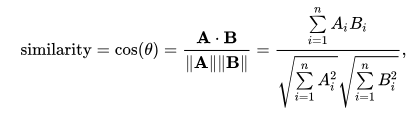

In [ ]:
dataRating['cast']=dataRating['cast'].fillna('Unknown')
dataRating['director']=dataRating['director'].fillna('Unknown')
dataRating['averageRating']=dataRating['averageRating'].fillna('0')
#combining all fields which will be used for recomendation
dataRating['CombinedField']=dataRating['cast']+' '+dataRating['director']+' '+str(dataRating['averageRating'])+' '+dataRating['listed_in']+' '+dataRating['description']
modifiedCOrpus=[]

In [ ]:
#tokenizing all words.
corpus = dataRating['CombinedField'].apply(lambda x:word_tokenize(x))
listcorpus = list(corpus)
modifiedCOrpus = []
#pre processing words, by lowering it, removing symbolls and removing stop words
for desc in listcorpus:
    stmt = []
    for i in desc:
        if i.lower() not in  stop_words:
            if i.lower() not in ['.',',','â€',':','""']:
                stmt.append(i.lower())
    modifiedCOrpus.append(' '.join(stmt))

The TF-IDF(Term Frequency-Inverse Document Frequency (TF-IDF) ) score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.



In [ ]:
tfdifVect = TfidfVectorizer(stop_words='english',lowercase=True)
corpus = modifiedCOrpus
tfdifCorpus =   tfdifVect.fit_transform(corpus)

In [ ]:
cossineSim = cosine_similarity(tfdifCorpus,tfdifCorpus)
def get_recommendations(title):
    indices = pd.Series(dataRating.index, index=dataRating['title']).drop_duplicates()
    try:
        idx = indices[title]
        # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(cossineSim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores of the 10 most similar movies
        sim_scores = sim_scores[1:11]
        movie_indices = [i[0] for i in sim_scores]
        print(dataRating['title'].iloc[movie_indices])
    except:
        print('No such movie found')

In [ ]:
get_recommendations('ABCD 2')

In [ ]:
get_recommendations('Amar Akbar Anthony')

In [ ]:
get_recommendations('PK')